### Import required libraries

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from collections import OrderedDict
import segmentation_models_pytorch as smp
import torch.optim as optim
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

# --- Set data path ---
DATA_DIR = "/Users/afra/Desktop/MRNetSegmentation/MnM2/dataset"

# --- Set output images path ---
PLOT_DIR = "/Users/afra/Desktop/MRNetSegmentation/All_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# --- Optional: set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Print current device status ---
print(f"Using device: {device}")

Using device: cpu


### Define the MnM2Dataset class

In [10]:
class MnM2Dataset(Dataset):
    def __init__(self, root_dir, patient_ids, modes=('ED', 'ES'), transform=None):
        """
        Args:
            root_dir (str): Path to dataset folder containing subject folders.
            patient_ids (list): List of subject IDs, e.g., ['001', '002'].
            modes (tuple): Cardiac phases to include, e.g., ('ED', 'ES') or ('ED',).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.modes = modes
        self.transform = transform
        self.samples = []

        for pid in self.patient_ids:
            for mode in self.modes:
                image_path = os.path.join(root_dir, pid, f"{pid}_SA_{mode}.nii.gz")
                label_path = os.path.join(root_dir, pid, f"{pid}_SA_{mode}_gt.nii.gz")
                if os.path.exists(image_path) and os.path.exists(label_path):
                    img = nib.load(image_path).get_fdata()
                    lbl = nib.load(label_path).get_fdata()
                    for i in range(img.shape[2]):
                        self.samples.append((img[:, :, i], lbl[:, :, i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_slice, lbl_slice = self.samples[idx]

        # Normalize image to [0, 1]
        img_slice = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice) + 1e-8)

        # Resize to 256x256
        img_slice = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        lbl_slice = cv2.resize(lbl_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Map label values to 0,1,2,3 (background, RV, Myocardium, LV)
        lbl_slice = np.where(lbl_slice == 500, 1, lbl_slice)  # RV
        lbl_slice = np.where(lbl_slice == 600, 2, lbl_slice)  # Myocardium
        lbl_slice = np.where(lbl_slice == 700, 3, lbl_slice)  # LV
        lbl_slice = np.where(~np.isin(lbl_slice, [0, 1, 2, 3]), 0, lbl_slice)  # Set unexpected to background

        # Expand channel for image
        img_slice = np.expand_dims(img_slice, axis=0)

        return {
            'image': torch.tensor(img_slice, dtype=torch.float32),
            'mask': torch.tensor(lbl_slice, dtype=torch.long)
        }

### Create Dataset and DataLoader

In [20]:
# Define patient IDs
all_patients = sorted(os.listdir(DATA_DIR))

# Training 80% and validation 20%
train_ids, val_ids = train_test_split(all_patients, test_size=0.2, random_state=2025)

# Create dataset with both ED and ES
train_dataset = MnM2Dataset(DATA_DIR, train_ids, modes=('ED', 'ES'))
val_dataset = MnM2Dataset(DATA_DIR, val_ids, modes=('ED', 'ES'))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Check one sample
sample = next(iter(train_loader))
print("Image shape:", sample['image'].shape)  # [8, 1, 256, 256]
print("Mask shape:", sample['mask'].shape)    # [8, 256, 256]

Image shape: torch.Size([8, 1, 256, 256])
Mask shape: torch.Size([8, 256, 256])


### Define the U-Net model structure - U-Net¶

In [28]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )

In [30]:
def dice_score(preds, targets, num_classes=4, ignore_background=True):
    preds = torch.argmax(preds, dim=1)
    classes = range(1, num_classes) if ignore_background else range(num_classes)
    dice = 0
    for cls in classes:
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += (2. * intersection / (union + 1e-6)) if union > 0 else 1
    return dice / len(classes)

def iou_score(preds, targets, num_classes=4, ignore_background=True):
    preds = torch.argmax(preds, dim=1)
    classes = range(1, num_classes) if ignore_background else range(num_classes)
    iou = 0
    for cls in classes:
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        iou += (intersection / (union + 1e-6)) if union > 0 else 1
    return iou / len(classes)

def plot_metrics(metrics, filename=os.path.join(PLOT_DIR, 'training_curves.png')):
    plt.figure(figsize=(10, 6))
    for key in metrics:
        plt.plot(metrics[key], label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training Metrics over Epochs')
    plt.savefig(filename, dpi=300)
    plt.close()

PALETTE = np.array([
    [0, 0, 0],       # background
    [255, 0, 0],     # RV
    [0, 255, 0],     # Myocardium
    [0, 0, 255]      # LV
], dtype=np.uint8)

def label_to_color(mask):
    return PALETTE[mask.astype(np.int32)]

def visualize_predictions_grid(images, preds, masks, save_path="grid_prediction.png", num_samples=4):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()

    num_samples = min(num_samples, images.shape[0])
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i][0], cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(label_to_color(masks[i]))
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(label_to_color(preds[i]))
        axes[i, 2].set_title("Prediction")
        for j in range(3):
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [33]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        output = self.model(input_tensor)
        assert 0 <= class_idx < output.shape[1], f"class_idx {class_idx} out of range"

        self.model.zero_grad()
        class_score = output[:, class_idx, :, :].sum()
        class_score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = torch.nn.functional.interpolate(
            cam.unsqueeze(1),
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        )
        return cam.squeeze().cpu().numpy()

In [36]:
# ========== Main ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet Model (4 classes: 0=bg, 1=RV, 2=Myo, 3=LV)
model = UNet(in_channels=1, out_channels=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
best_dice = 0.0

# Grad-CAM config
CLASS_IDX_LIST = [1, 2, 3]  # RV, Myocardium, LV
CLASS_NAME = {1: "RV", 2: "Myo", 3: "LV"}
GRADCAM_EVERY_N_EPOCHS = 1

history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
    'val_iou': []
}

for epoch in range(epochs):
    model.train()
    train_loss, train_dice = 0.0, 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        images = batch['image'].to(device)           # [B,1,256,256]
        masks = batch['mask'].to(device).long()      # [B,256,256] 

        outputs = model(images)                      # [B,4,H,W]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()
            val_iou  += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)

    # Save best by val Dice (mean over RV/Myo/LV)
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")

    # Visualize predictions
    visualize_predictions_grid(
        images, outputs, masks,
        save_path=os.path.join(PLOT_DIR, f"epoch_{epoch+1:02d}_prediction.png"),
        num_samples=4
    )

    # Grad-CAM on bottleneck
    if (epoch + 1) % GRADCAM_EVERY_N_EPOCHS == 0 and images.shape[0] > 0:
        gradcam = GradCAM(model, target_layer=model.bottleneck)
        test_image = images[0].unsqueeze(0)  # [1,1,H,W]

        orig_img = test_image[0, 0].detach().cpu().numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-8)
        orig_img_rgb = np.stack([orig_img]*3, axis=-1)

        for class_idx in CLASS_IDX_LIST:
            cam = gradcam.generate(test_image, class_idx=class_idx)  # [H,W] in [0,1]
            cam_resized = cv2.resize(cam, (orig_img_rgb.shape[1], orig_img_rgb.shape[0]))
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
            overlay = np.clip(heatmap * 0.4 + orig_img_rgb * 0.6, 0, 1)

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(orig_img_rgb); axs[0].set_title("Original"); axs[0].axis('off')
            axs[1].imshow(cam_resized, cmap='jet'); axs[1].set_title(f"Grad-CAM ({CLASS_NAME[class_idx]})"); axs[1].axis('off')
            axs[2].imshow(overlay); axs[2].set_title("Overlay"); axs[2].axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, f"gradcam_{CLASS_NAME[class_idx]}_epoch{epoch+1:02d}.png"), dpi=300)
            plt.close()

# Plot curves
plot_metrics(history, filename=os.path.join(PLOT_DIR, "training_curves.png"))

Epoch 1/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 1 Summary:
Train Loss: 0.5426 | Dice: 0.4286
Val   Loss: 0.2470 | Dice: 0.7809 | IoU: 0.6589
✅ Best model saved!


Epoch 2/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 2 Summary:
Train Loss: 0.1434 | Dice: 0.8176
Val   Loss: 0.0837 | Dice: 0.8368 | IoU: 0.7343
✅ Best model saved!


Epoch 3/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 3 Summary:
Train Loss: 0.0585 | Dice: 0.8557
Val   Loss: 0.0424 | Dice: 0.8548 | IoU: 0.7579
✅ Best model saved!


Epoch 4/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 4 Summary:
Train Loss: 0.0330 | Dice: 0.8753
Val   Loss: 0.0311 | Dice: 0.8576 | IoU: 0.7639
✅ Best model saved!


Epoch 5/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 5 Summary:
Train Loss: 0.0235 | Dice: 0.8824
Val   Loss: 0.0234 | Dice: 0.8648 | IoU: 0.7728
✅ Best model saved!


Epoch 6/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 6 Summary:
Train Loss: 0.0177 | Dice: 0.8943
Val   Loss: 0.0201 | Dice: 0.8758 | IoU: 0.7865
✅ Best model saved!


Epoch 7/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 7 Summary:
Train Loss: 0.0147 | Dice: 0.8988
Val   Loss: 0.0177 | Dice: 0.8779 | IoU: 0.7908
✅ Best model saved!


Epoch 8/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 8 Summary:
Train Loss: 0.0134 | Dice: 0.9019
Val   Loss: 0.0251 | Dice: 0.8468 | IoU: 0.7507


Epoch 9/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 9 Summary:
Train Loss: 0.0118 | Dice: 0.9072
Val   Loss: 0.0182 | Dice: 0.8815 | IoU: 0.7965
✅ Best model saved!


Epoch 10/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 10 Summary:
Train Loss: 0.0106 | Dice: 0.9139
Val   Loss: 0.0157 | Dice: 0.8867 | IoU: 0.8048
✅ Best model saved!


Epoch 11/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 11 Summary:
Train Loss: 0.0097 | Dice: 0.9186
Val   Loss: 0.0171 | Dice: 0.8741 | IoU: 0.7864


Epoch 12/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 12 Summary:
Train Loss: 0.0094 | Dice: 0.9201
Val   Loss: 0.0159 | Dice: 0.8875 | IoU: 0.8057
✅ Best model saved!


Epoch 13/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 13 Summary:
Train Loss: 0.0093 | Dice: 0.9203
Val   Loss: 0.0168 | Dice: 0.8893 | IoU: 0.8078
✅ Best model saved!


Epoch 14/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 14 Summary:
Train Loss: 0.0093 | Dice: 0.9190
Val   Loss: 0.0160 | Dice: 0.8905 | IoU: 0.8110
✅ Best model saved!


Epoch 15/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 15 Summary:
Train Loss: 0.0079 | Dice: 0.9285
Val   Loss: 0.0192 | Dice: 0.8823 | IoU: 0.7991


Epoch 16/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 16 Summary:
Train Loss: 0.0074 | Dice: 0.9327
Val   Loss: 0.0167 | Dice: 0.8864 | IoU: 0.8043


Epoch 17/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 17 Summary:
Train Loss: 0.0081 | Dice: 0.9275
Val   Loss: 0.0171 | Dice: 0.8916 | IoU: 0.8122
✅ Best model saved!


Epoch 18/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 18 Summary:
Train Loss: 0.0079 | Dice: 0.9295
Val   Loss: 0.0171 | Dice: 0.8928 | IoU: 0.8130
✅ Best model saved!


Epoch 19/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 19 Summary:
Train Loss: 0.0075 | Dice: 0.9323
Val   Loss: 0.0165 | Dice: 0.8933 | IoU: 0.8145
✅ Best model saved!


Epoch 20/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 20 Summary:
Train Loss: 0.0068 | Dice: 0.9374
Val   Loss: 0.0182 | Dice: 0.8927 | IoU: 0.8133


Epoch 21/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 21 Summary:
Train Loss: 0.0074 | Dice: 0.9333
Val   Loss: 0.0191 | Dice: 0.8944 | IoU: 0.8166
✅ Best model saved!


Epoch 22/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 22 Summary:
Train Loss: 0.0063 | Dice: 0.9416
Val   Loss: 0.0167 | Dice: 0.8924 | IoU: 0.8138


Epoch 23/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 23 Summary:
Train Loss: 0.0060 | Dice: 0.9433
Val   Loss: 0.0184 | Dice: 0.8929 | IoU: 0.8137


Epoch 24/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 24 Summary:
Train Loss: 0.0060 | Dice: 0.9446
Val   Loss: 0.0198 | Dice: 0.8909 | IoU: 0.8103


Epoch 25/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 25 Summary:
Train Loss: 0.0076 | Dice: 0.9334
Val   Loss: 0.0174 | Dice: 0.8920 | IoU: 0.8126


Epoch 26/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 26 Summary:
Train Loss: 0.0060 | Dice: 0.9442
Val   Loss: 0.0185 | Dice: 0.8959 | IoU: 0.8197
✅ Best model saved!


Epoch 27/30 - Validation: 100%|██████████| 201/201 [02:41<00:00,  1.24it/s]



Epoch 27 Summary:
Train Loss: 0.0060 | Dice: 0.9446
Val   Loss: 0.0180 | Dice: 0.8960 | IoU: 0.8196
✅ Best model saved!


Epoch 28/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 28 Summary:
Train Loss: 0.0058 | Dice: 0.9460
Val   Loss: 0.0177 | Dice: 0.8848 | IoU: 0.8018


Epoch 29/30 - Validation: 100%|██████████| 201/201 [02:42<00:00,  1.24it/s]



Epoch 29 Summary:
Train Loss: 0.0055 | Dice: 0.9485
Val   Loss: 0.0203 | Dice: 0.8924 | IoU: 0.8139


Epoch 30/30 - Validation: 100%|██████████| 201/201 [02:43<00:00,  1.23it/s]



Epoch 30 Summary:
Train Loss: 0.0053 | Dice: 0.9507
Val   Loss: 0.0195 | Dice: 0.8875 | IoU: 0.8062


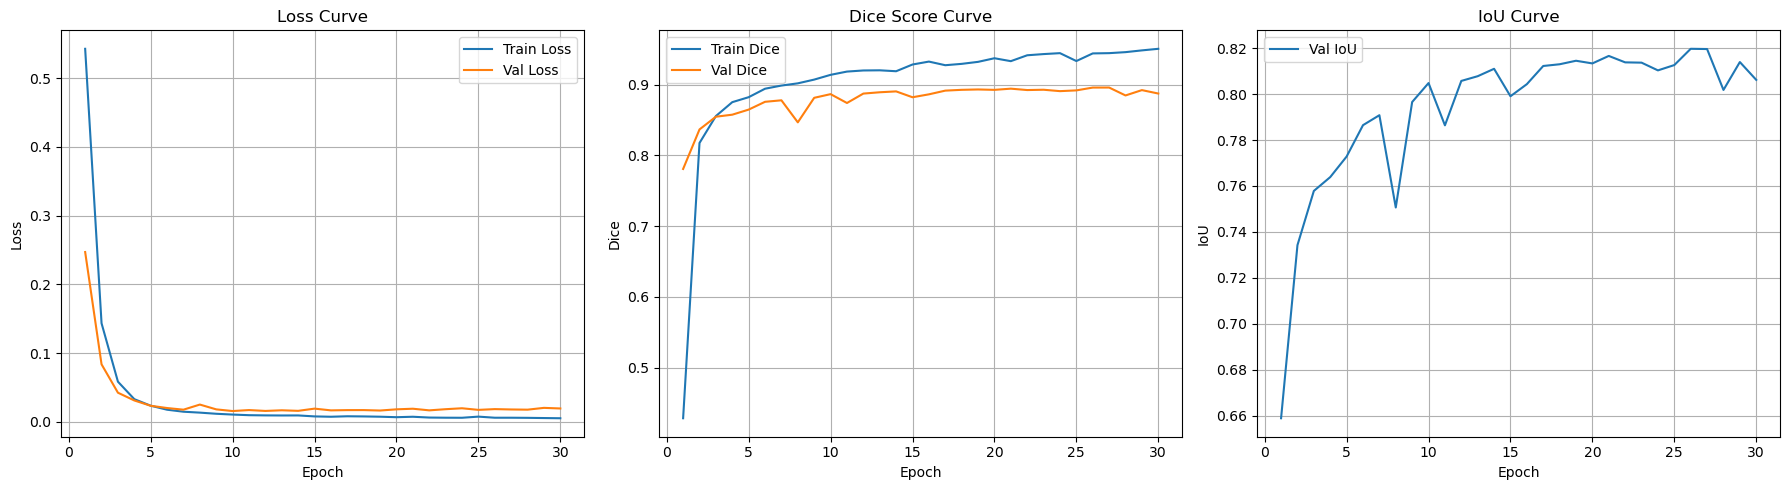

In [90]:
def plot_loss_dice(history, save_path="training_curves.png"):
    epochs = range(1, len(history['train_loss']) + 1)

    has_iou = 'val_iou' in history and len(history['val_iou']) == len(history['val_loss'])
    ncols = 3 if has_iou else 2

    fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 5))

    # ---- 1) Loss ----
    ax = axs[0] if ncols > 1 else axs
    ax.plot(epochs, history['train_loss'], label='Train Loss')
    ax.plot(epochs, history['val_loss'],   label='Val Loss')
    ax.set_title('Loss Curve'); ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend(); ax.grid(True)

    # ---- 2) Dice (mean, ignore bg) ----
    ax = axs[1] if ncols > 1 else axs
    ax.plot(epochs, history['train_dice'], label='Train Dice')
    ax.plot(epochs, history['val_dice'],   label='Val Dice')
    ax.set_title('Dice Score Curve'); ax.set_xlabel('Epoch'); ax.set_ylabel('Dice')
    ax.legend(); ax.grid(True)

    # ---- 3) IoU ----
    if has_iou:
        ax = axs[2]
        ax.plot(epochs, history['val_iou'], label='Val IoU')
        ax.set_title('IoU Curve'); ax.set_xlabel('Epoch'); ax.set_ylabel('IoU')
        ax.legend(); ax.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

plot_loss_dice(history, save_path=os.path.join(PLOT_DIR, "loss_dice_curves.png"))

In [53]:
best_epoch = history['val_dice'].index(max(history['val_dice'])) + 1
best_val_dice = history['val_dice'][best_epoch - 1]
best_val_loss = history['val_loss'][best_epoch - 1]
best_val_iou  = history['val_iou'][best_epoch - 1]

print("\n✅ Best Model (on Validation Set):")
print(f"Best Epoch     : {best_epoch}")
print(f"Val Dice       : {best_val_dice:.4f}")
print(f"Val IoU        : {best_val_iou:.4f}")
print(f"Val Loss       : {best_val_loss:.4f}")


✅ Best Model (on Validation Set):
Best Epoch     : 27
Val Dice       : 0.8960
Val IoU        : 0.8196
Val Loss       : 0.0180


Grad-CAM for RV at Epoch 7


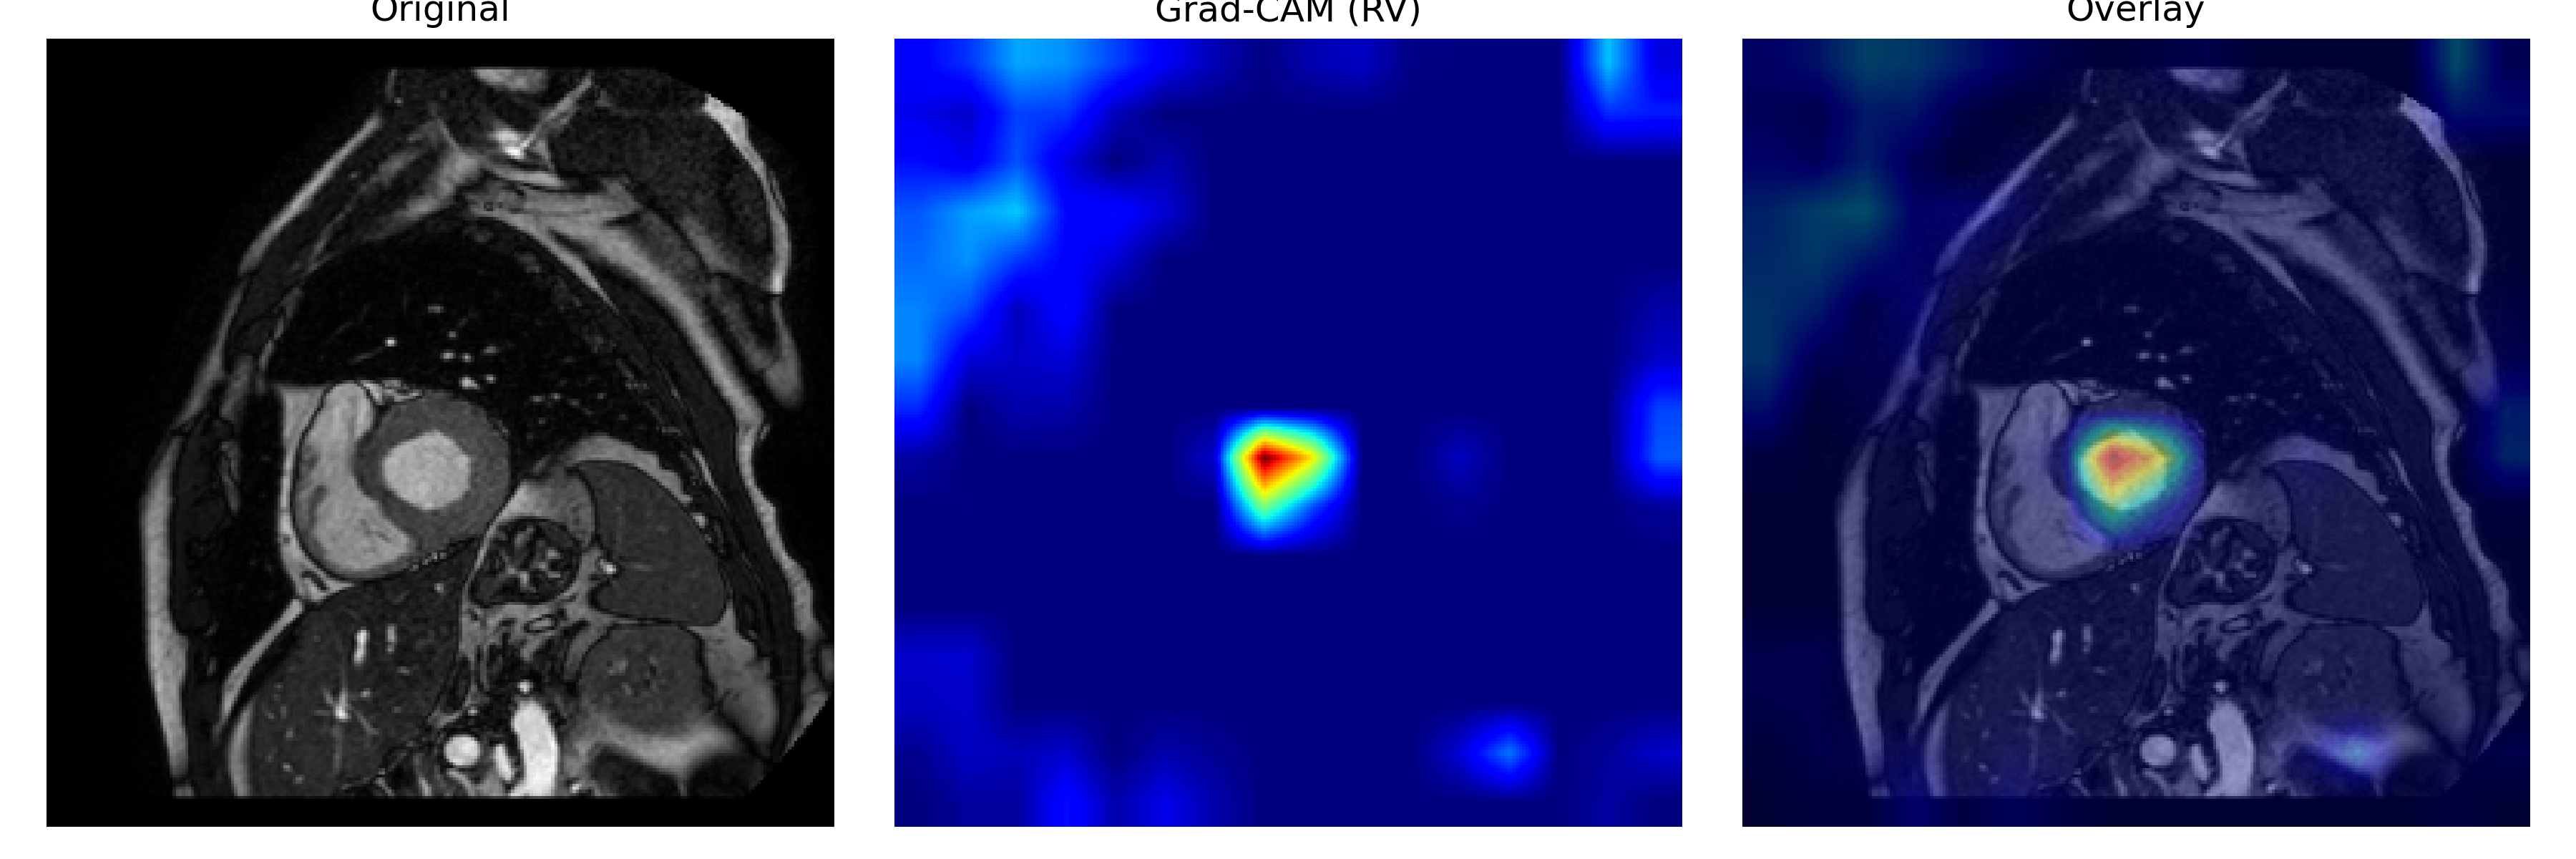

Grad-CAM for RV at Epoch 17


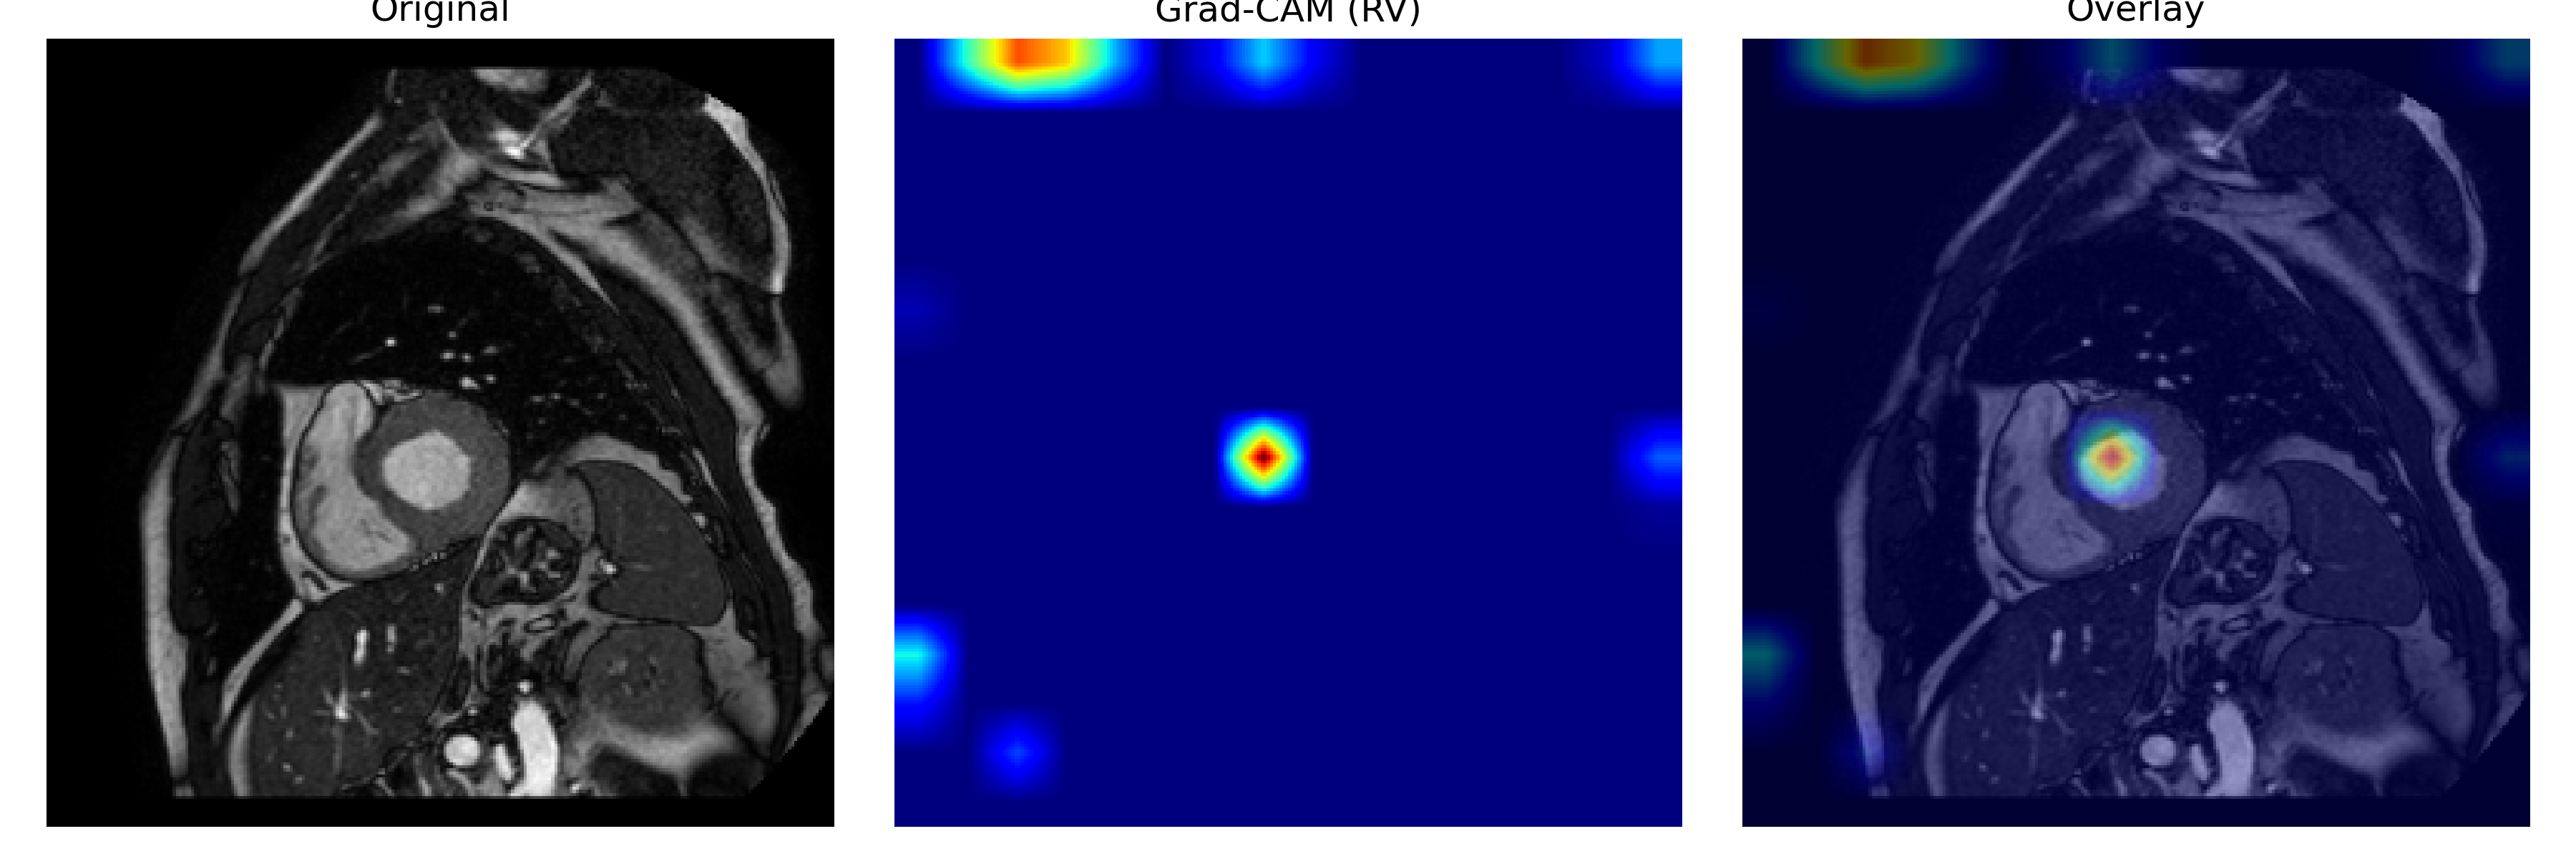

Grad-CAM for RV at Epoch 27


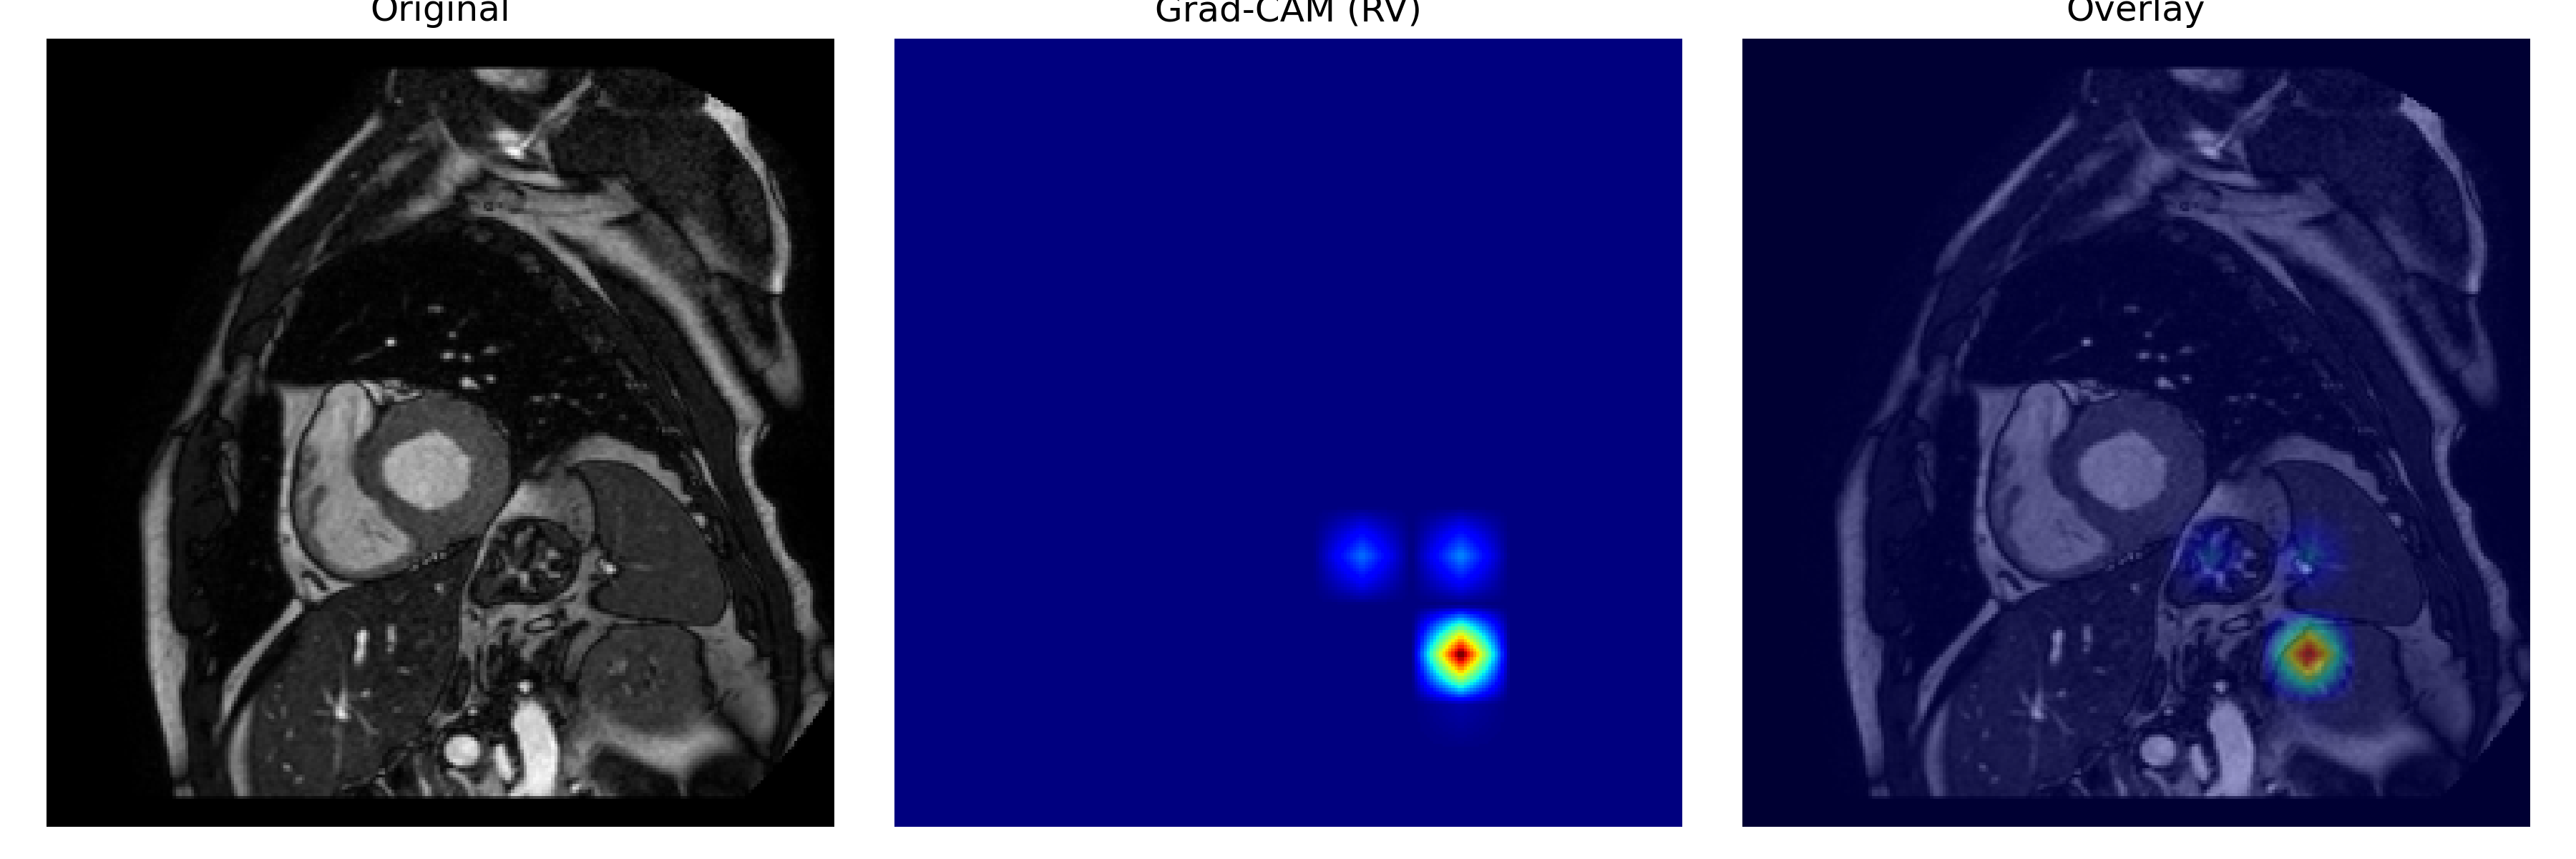

Grad-CAM for Myo at Epoch 7


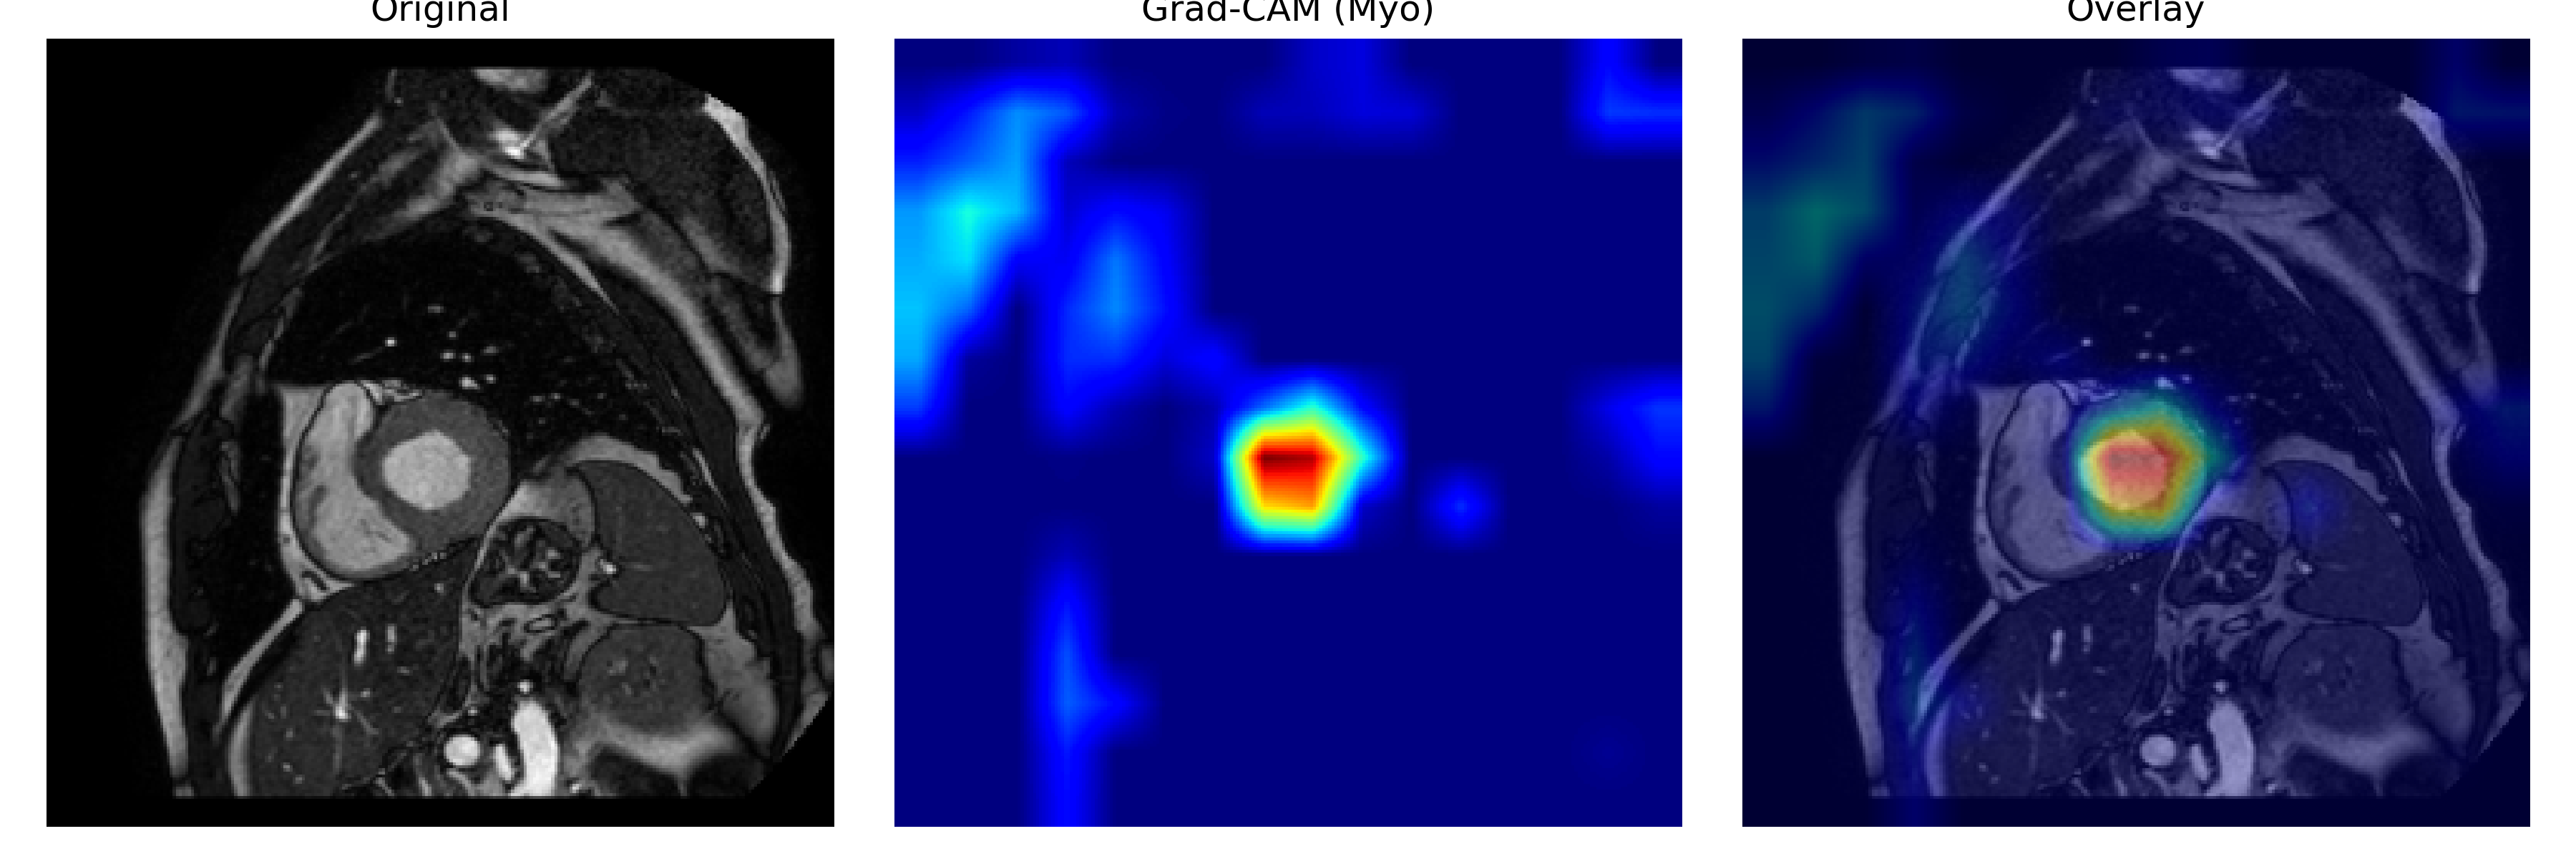

Grad-CAM for Myo at Epoch 17


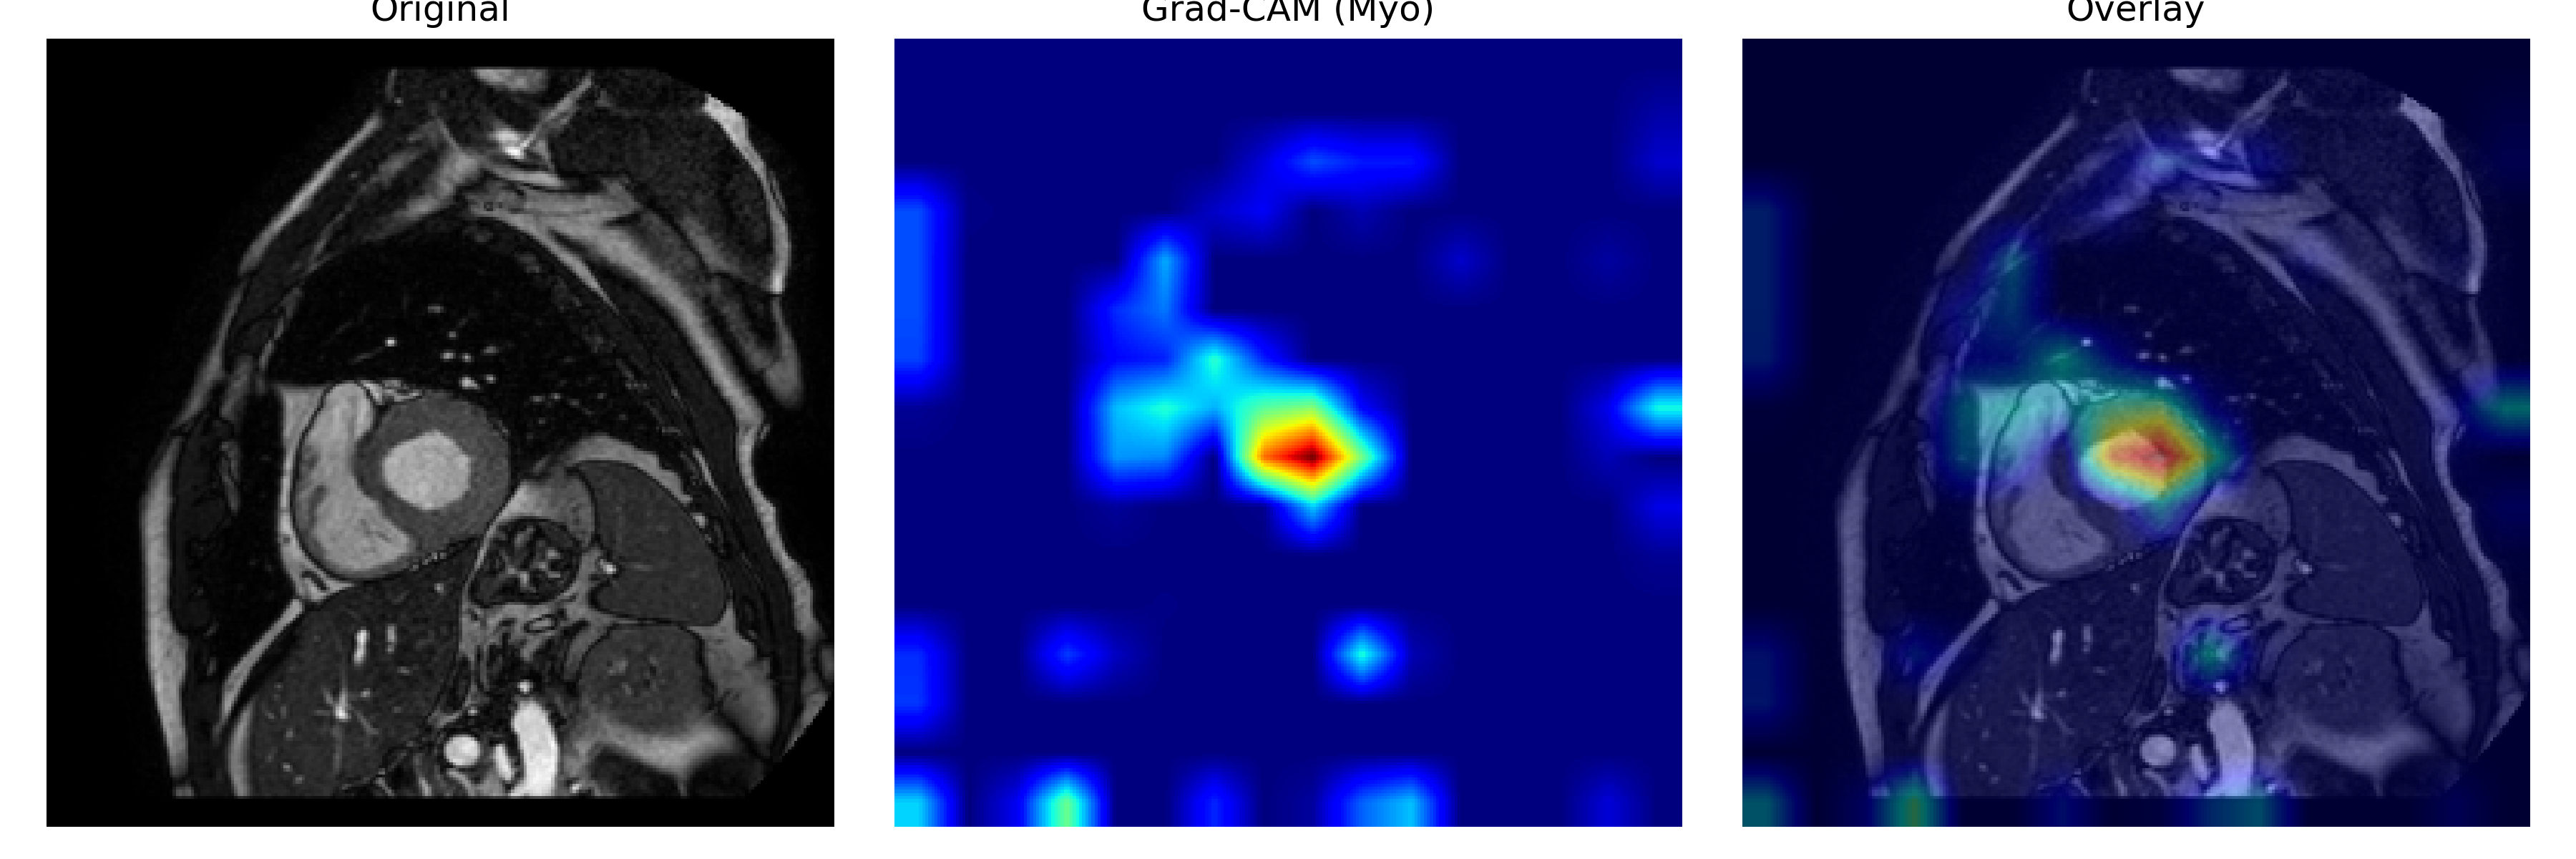

Grad-CAM for Myo at Epoch 27


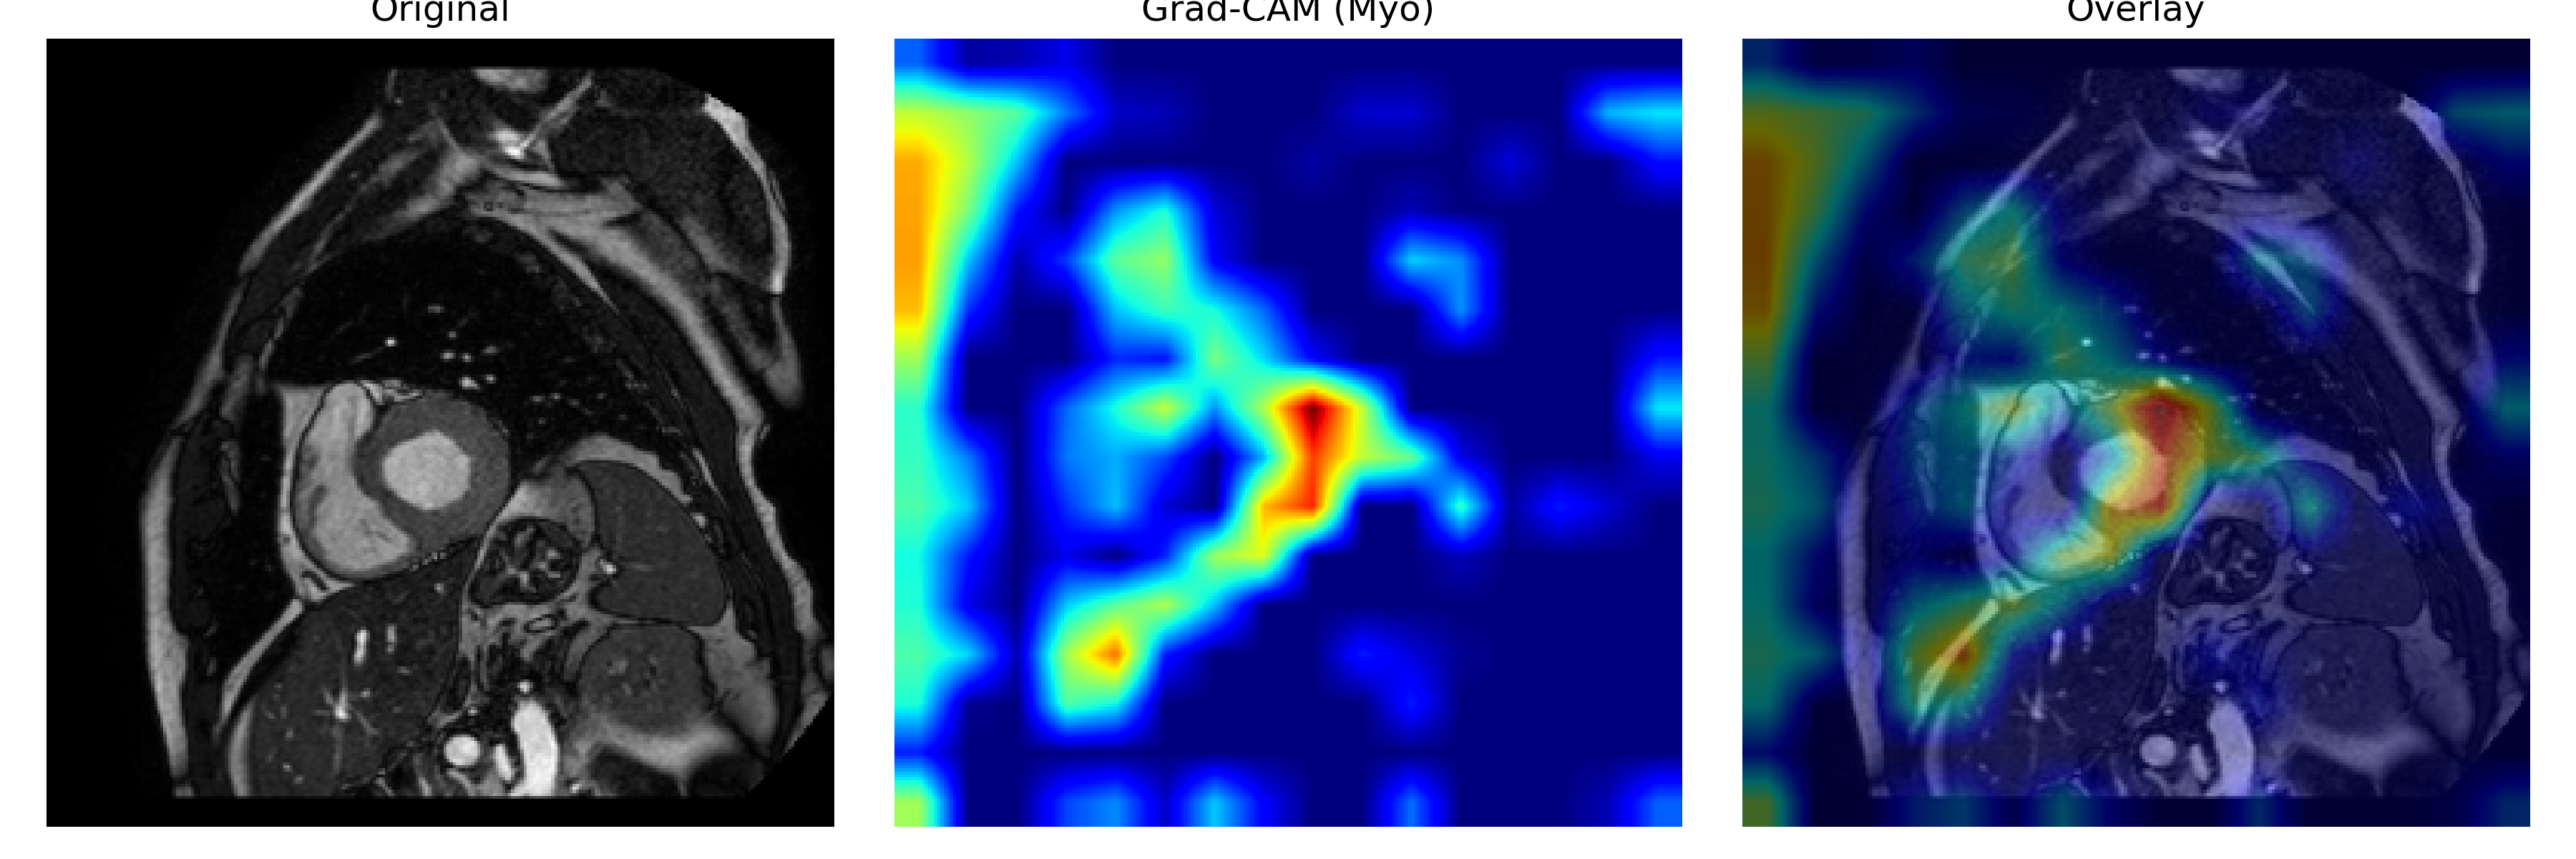

Grad-CAM for LV at Epoch 7


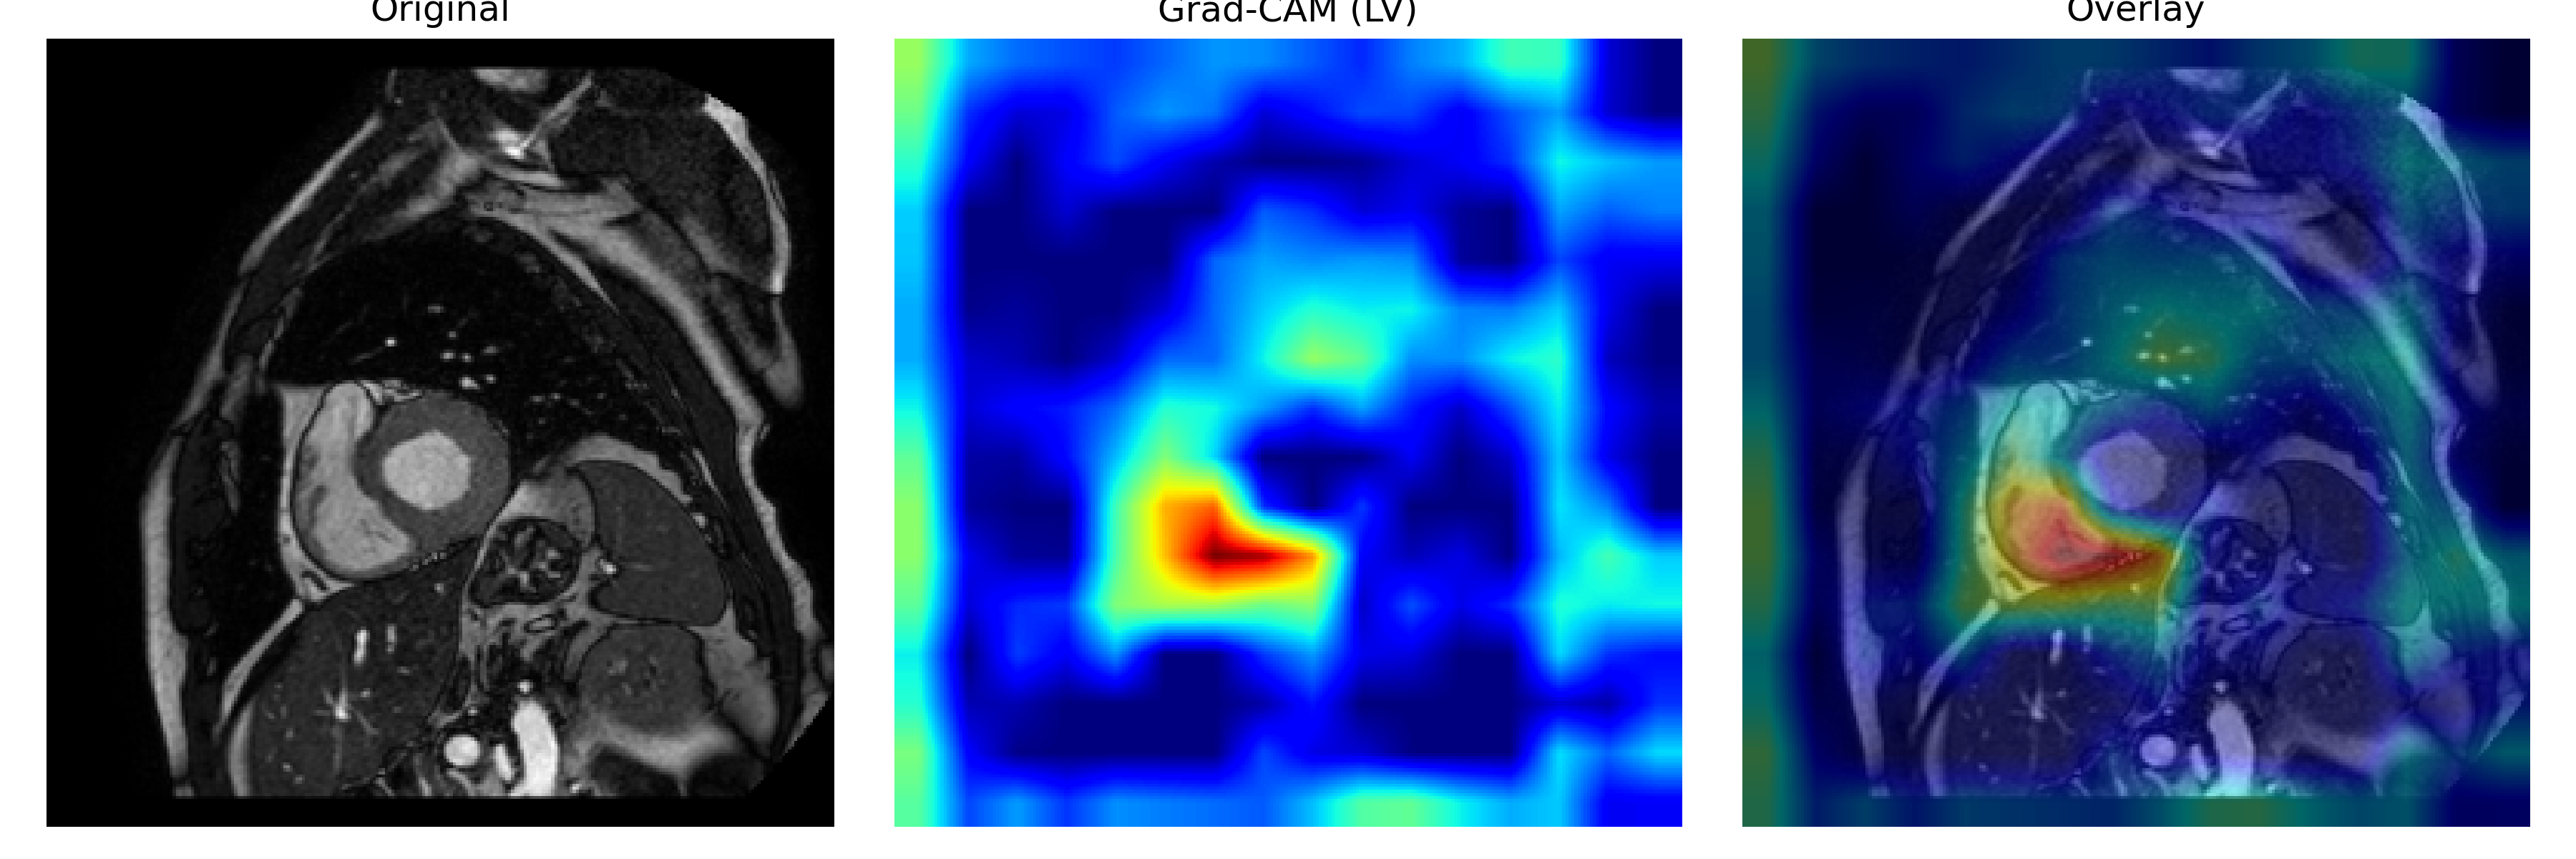

Grad-CAM for LV at Epoch 17


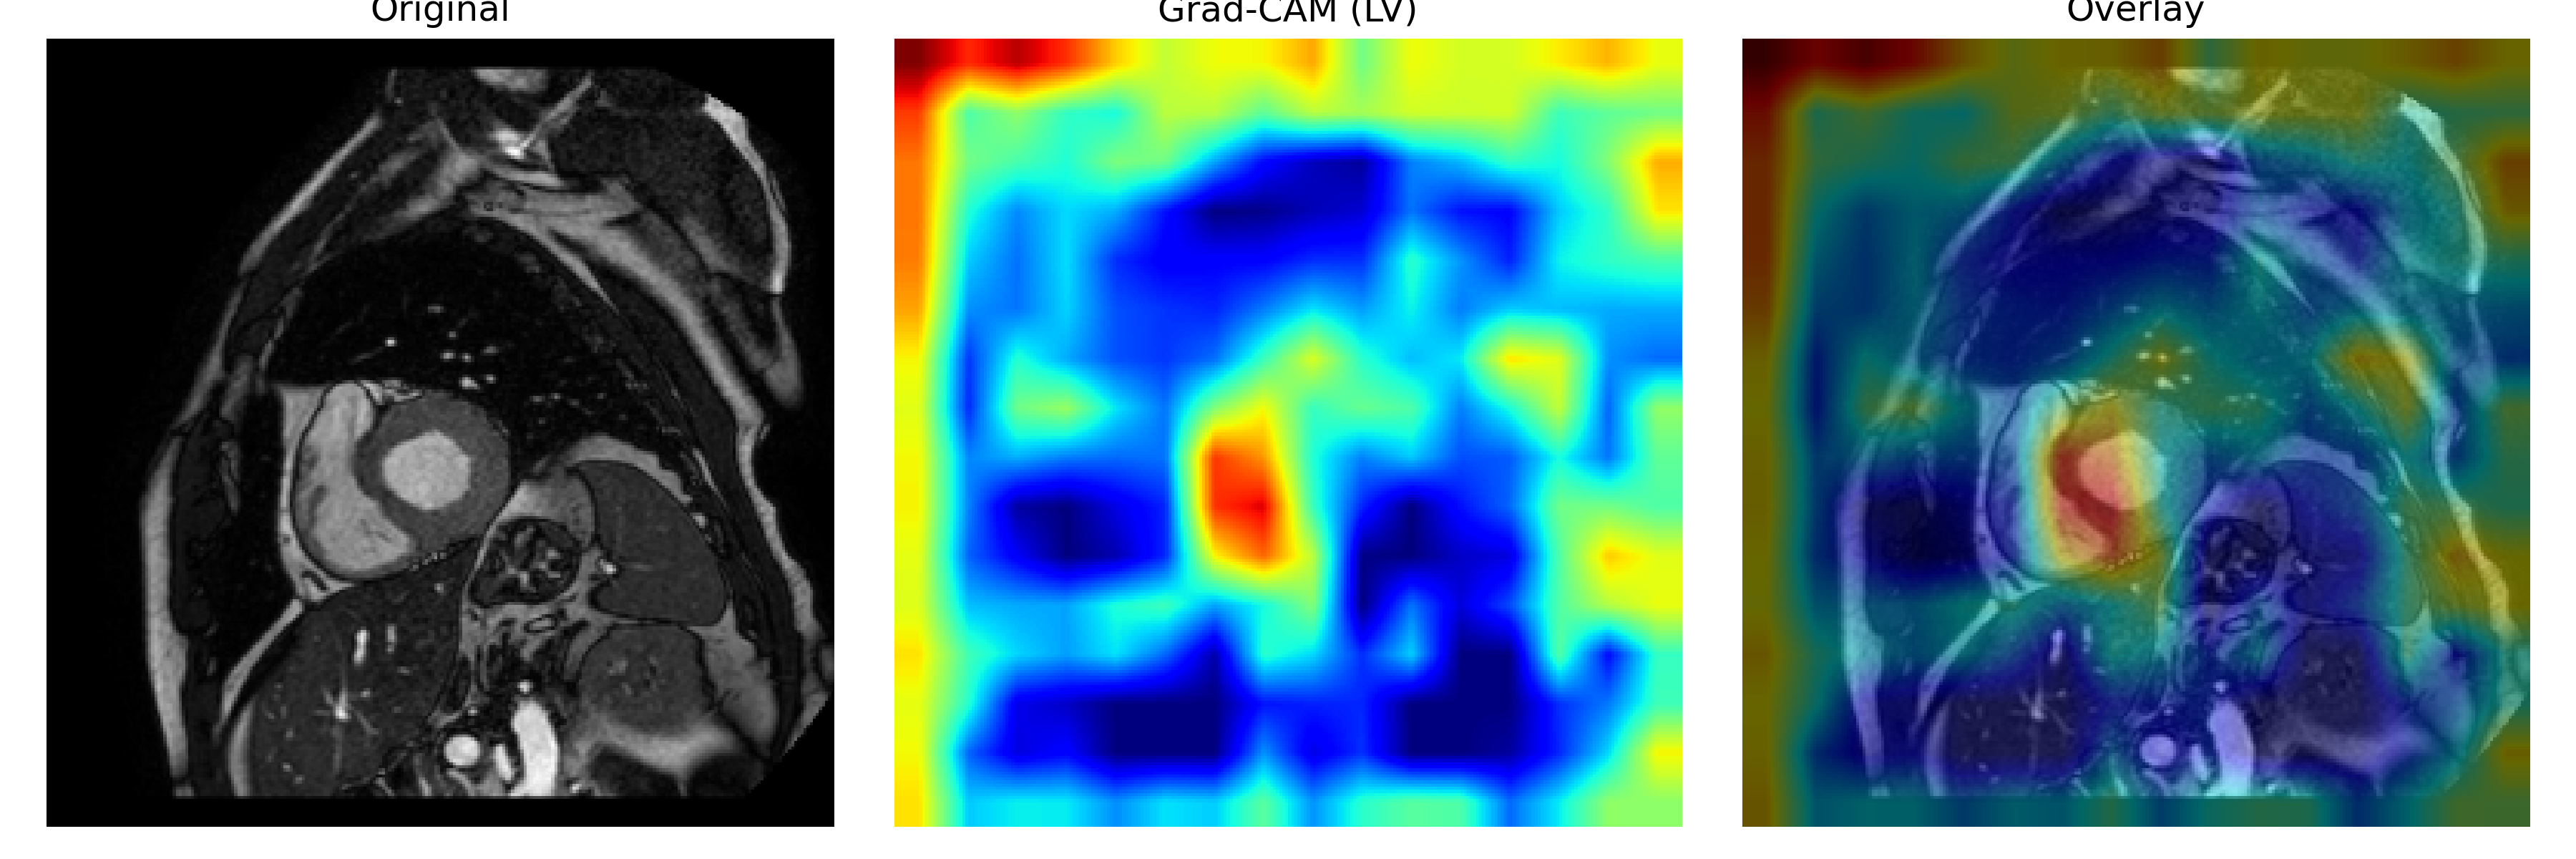

Grad-CAM for LV at Epoch 27


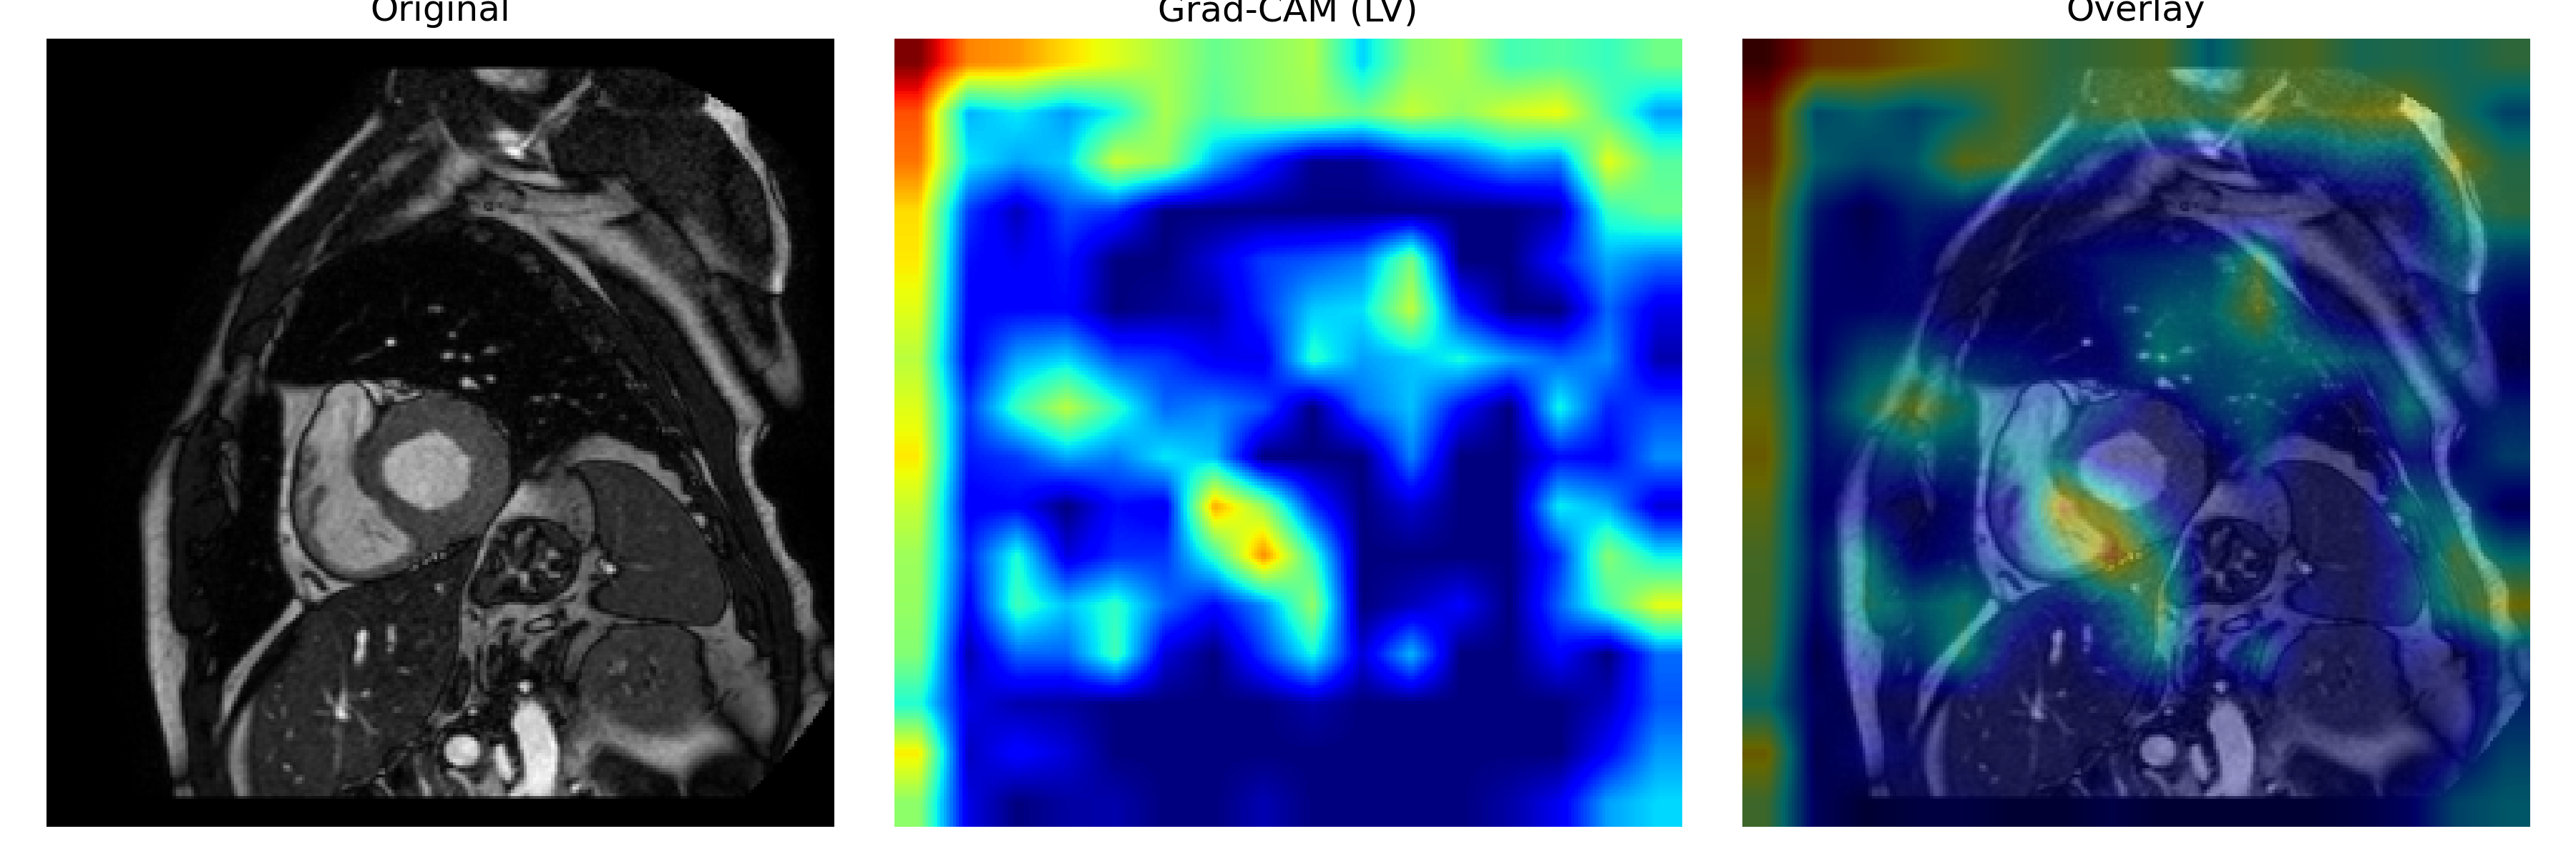

In [62]:
classes = ["RV", "Myo", "LV"]
for cls in classes:
    for epoch in [7, 17, 27]:
        path = os.path.join(PLOT_DIR, f"gradcam_{cls}_epoch{epoch:02d}.png")
        print(f"Grad-CAM for {cls} at Epoch {epoch}")
        display(Image(filename=path))

### Use best_model.pth to make predictions on the validation set

In [65]:
# Load the model
model = UNet(in_channels=1, out_channels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.device = device
model.eval()

test_dataset = MnM2Dataset(DATA_DIR, val_ids, modes=('ED', 'ES'))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### Define evaluation function

In [72]:
def run_test_evaluation(model, test_loader, plot_dir, num_samples=5):
    model.eval()
    total_dice = 0
    total_iou = 0
    total = 0
    count = 0
    os.makedirs(plot_dir, exist_ok=True)

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(model.device)
            masks = batch['mask'].to(model.device)
            outputs = model(images)

            # calculation indicators
            total_dice += dice_score(outputs, masks, num_classes=4, ignore_background=True)
            total_iou  += iou_score(outputs, masks, num_classes=4, ignore_background=True)
            total += 1

            # save top num_samples prediction images
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.shape[0]):
                if count >= num_samples:
                    break
                image = images[i][0].cpu().numpy()
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap='gray')
                plt.title("Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(label_to_color(mask))
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(label_to_color(pred))
                plt.title("Prediction")
                plt.axis('off')

                plt.tight_layout()
                save_path = os.path.join(plot_dir, f"test_prediction_{count+1}.png")
                plt.savefig(save_path, dpi=300)
                plt.close()
                print(f"✅ Saved: {save_path}")
                count += 1

    avg_dice = total_dice / total
    avg_iou = total_iou / total

    return avg_dice, avg_iou, count

In [74]:
avg_dice, avg_iou, sample_count = run_test_evaluation(
    model, test_loader, PLOT_DIR, num_samples=10)

print(f"\n📊 Test Evaluation Summary:")
print(f"Average Dice Score (mean RV/Myo/LV): {avg_dice:.4f}")
print(f"Average IoU Score  (mean RV/Myo/LV): {avg_iou:.4f}")
print(f"Saved {sample_count} prediction images to: {PLOT_DIR}")

✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_1.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_2.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_3.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_4.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_5.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_6.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_7.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_8.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_9.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_10.png

📊 Test Evaluation Summary:
Average Dice Score (mean RV/Myo/LV): 0.8781
Average IoU Score  (mean RV/Myo/LV): 0.8337
Saved 10 prediction images to: /Users/afra/Desktop/MRNetSegmentation/All_plots


Prediction image - 2


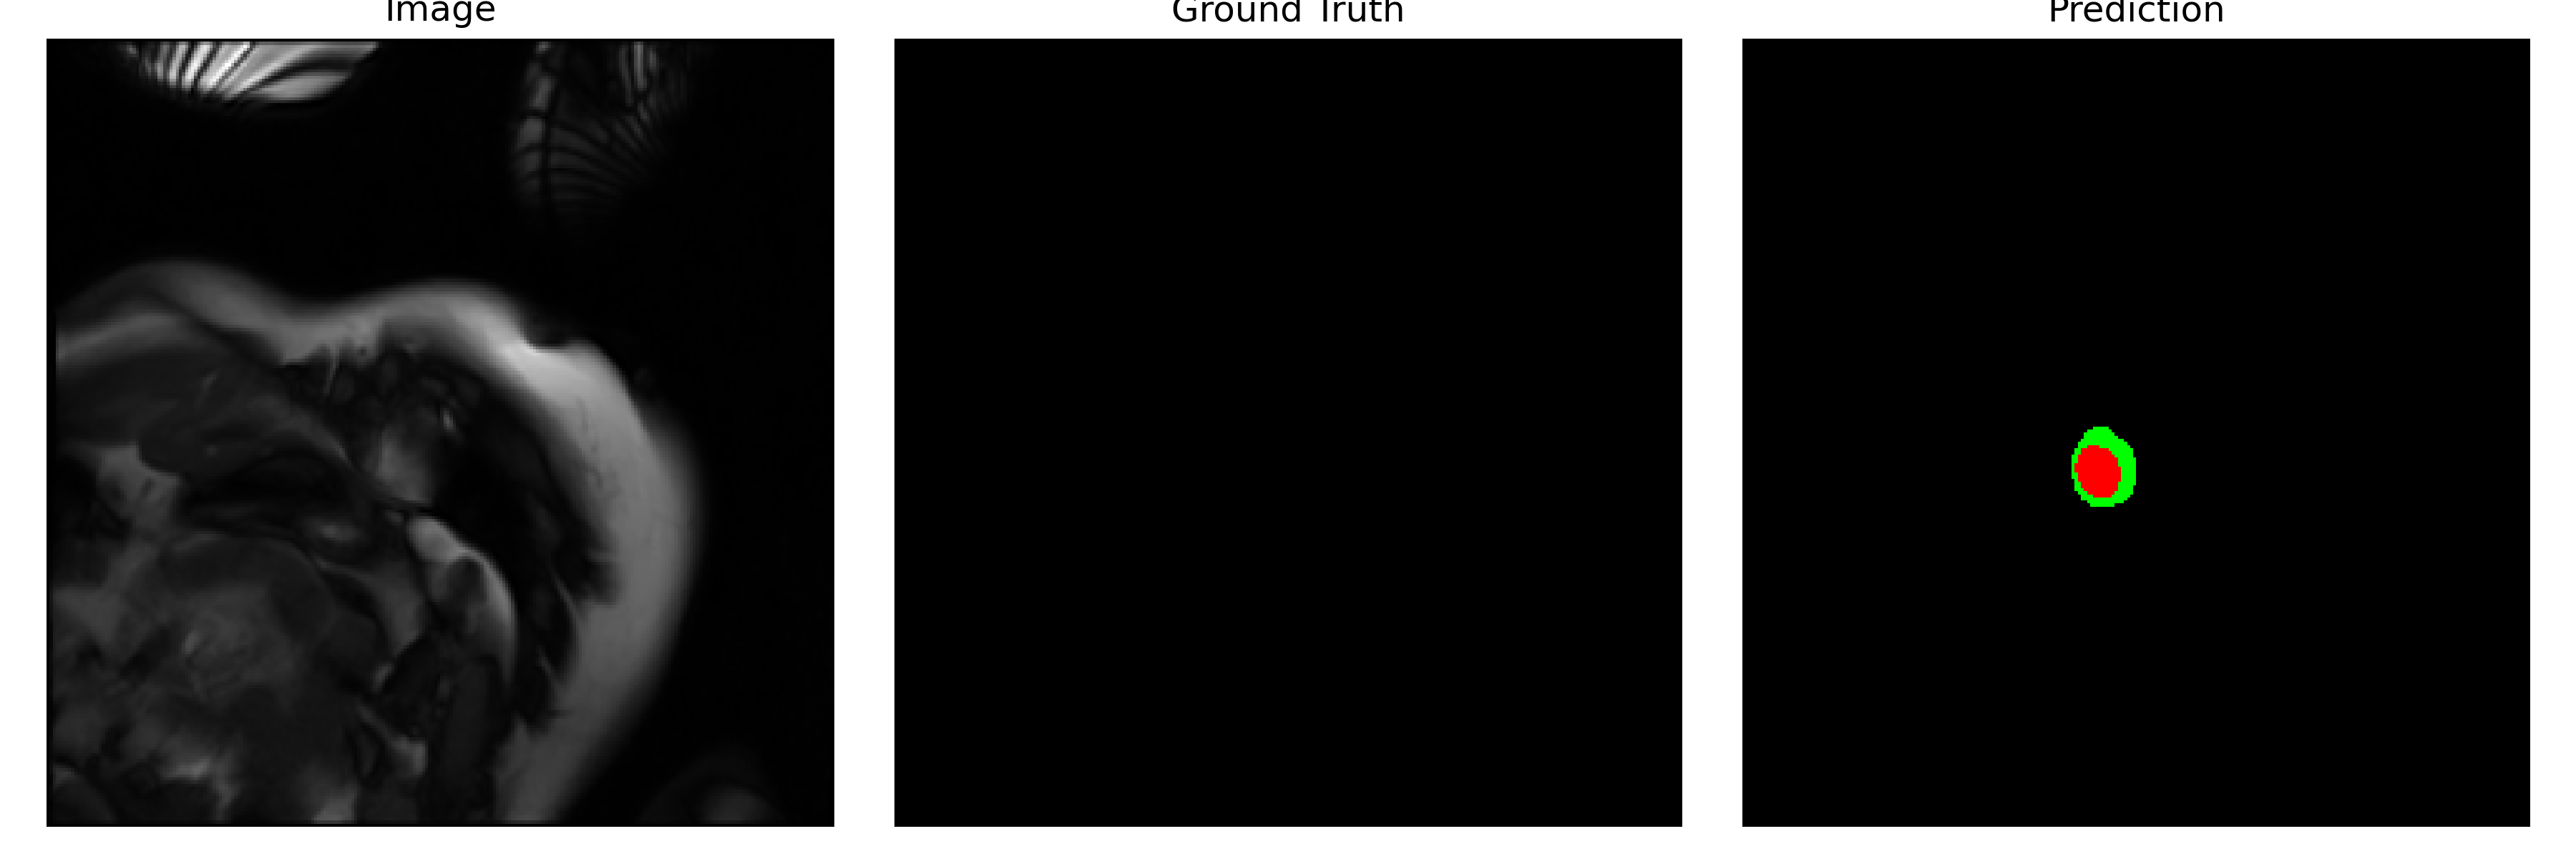

Prediction image - 5


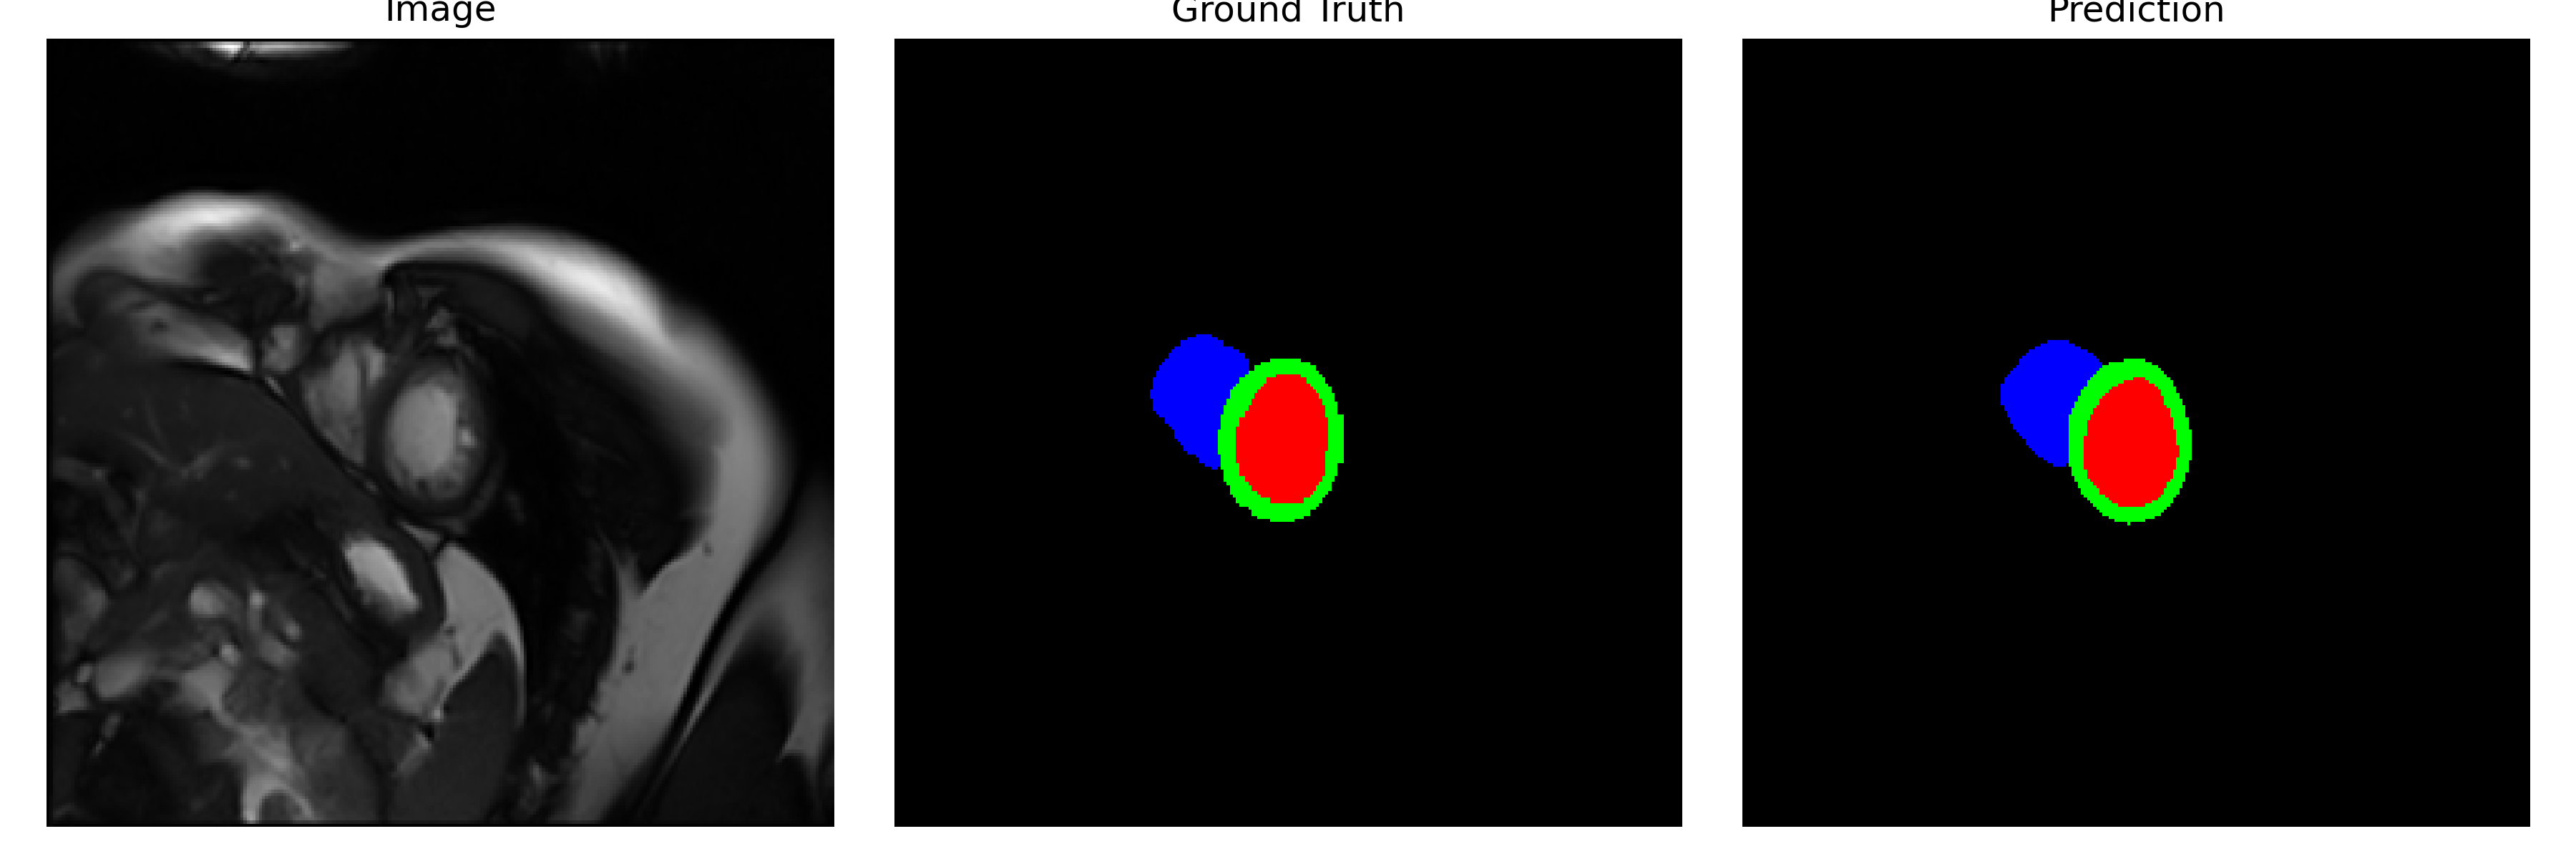

Prediction image - 10


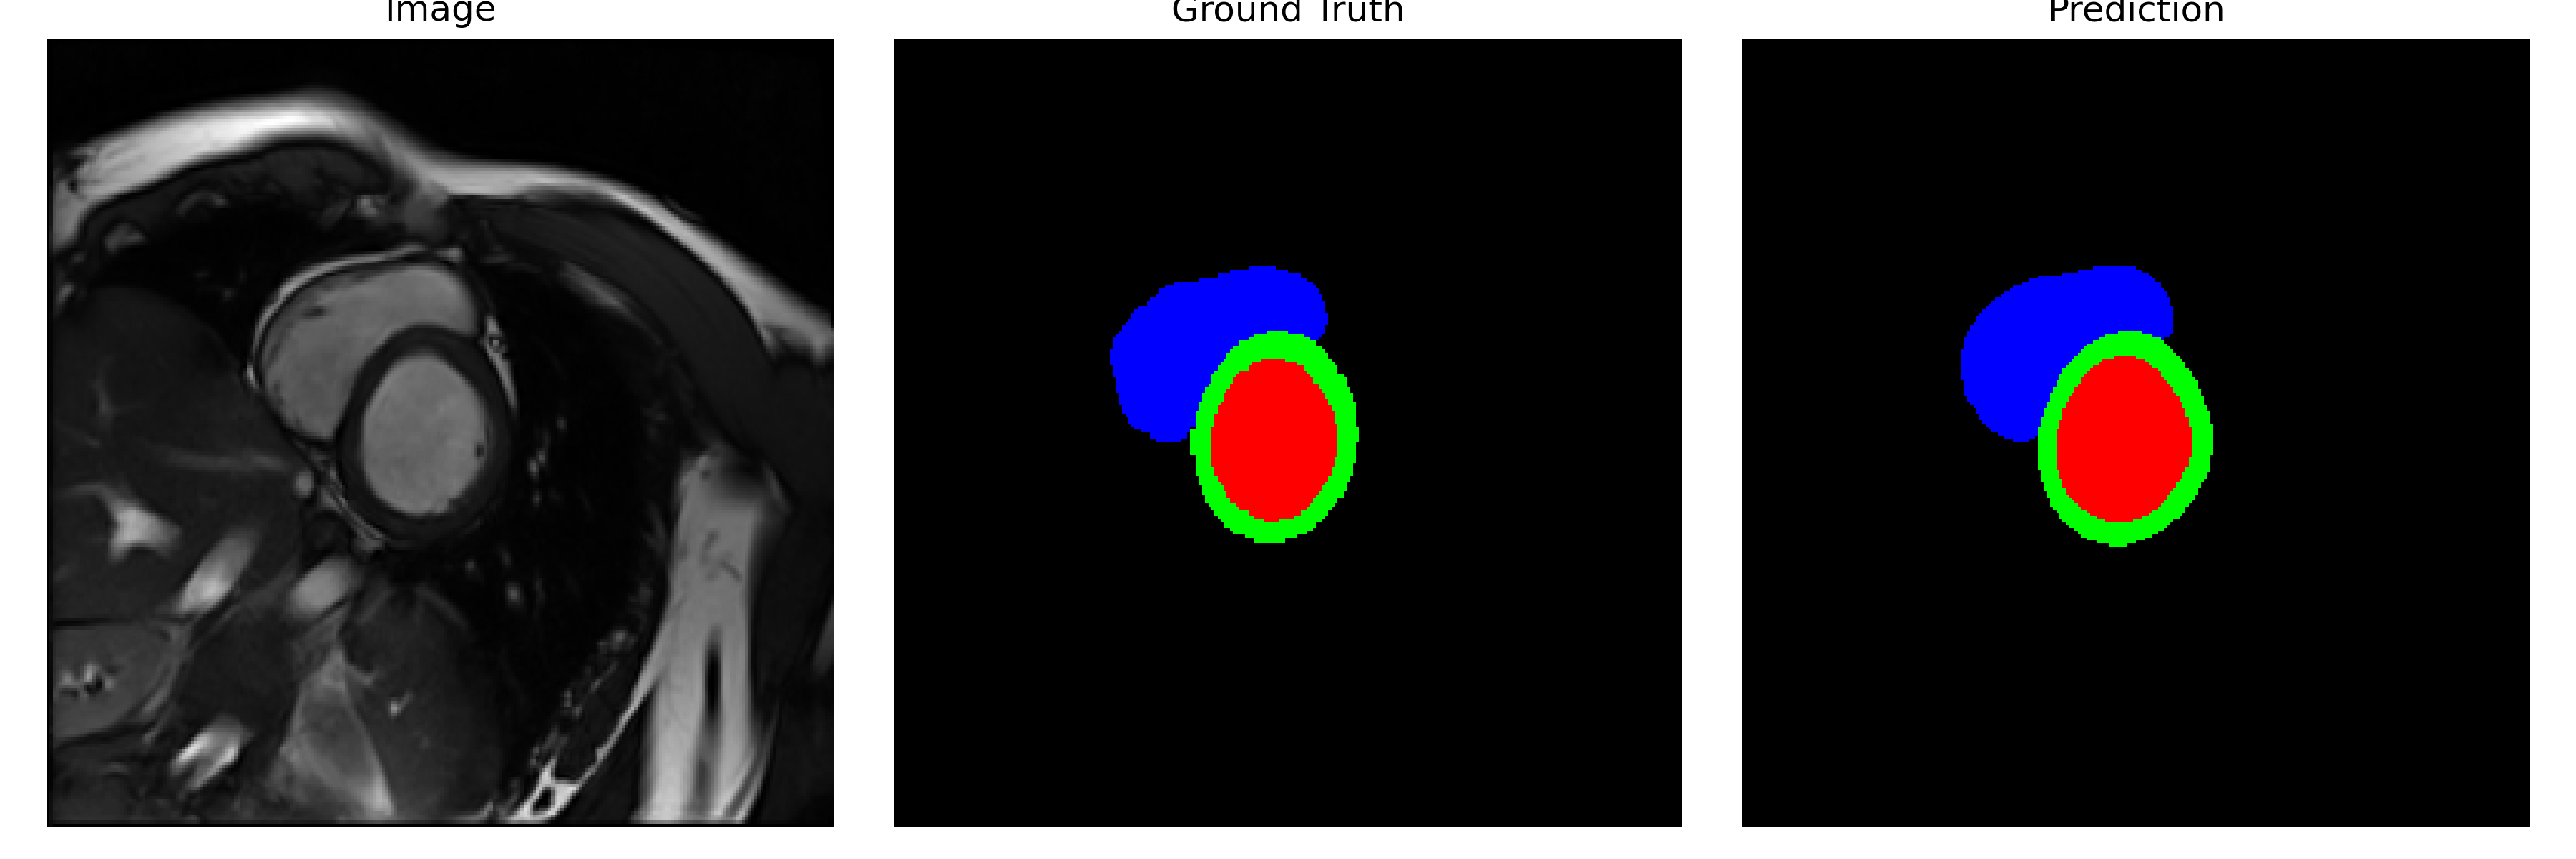

In [77]:
for count in [2, 5, 10]:
    path = os.path.join(PLOT_DIR, f"test_prediction_{count}.png")
    print(f"Prediction image - {count}")
    display(Image(filename=path))

In [79]:
import random
random.seed(2025)

def run_test_evaluation(model, test_loader, plot_dir, num_samples=5):
    """
    Evaluate model on the test set and randomly visualize sample predictions.

    Args:
        model: Trained segmentation model.
        test_loader: DataLoader for test set.
        plot_dir: Directory to save prediction plots.
        num_samples: Number of test samples to visualize (randomly selected).

    Returns:
        avg_dice: Average Dice score (mean over RV/Myo/LV).
        avg_iou: Average IoU score (mean over RV/Myo/LV).
        count: Number of samples visualized.
    """
    model.eval()
    os.makedirs(plot_dir, exist_ok=True)

    # Store all images, ground truths, and predictions
    all_images = []
    all_masks = []
    all_preds = []

    total_dice = 0.0
    total_iou = 0.0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(model.device)
            masks = batch['mask'].to(model.device)
            outputs = model(images)

            # Metrics (4 classes, ignore background)
            total_dice += dice_score(outputs, masks, num_classes=4, ignore_background=True)
            total_iou  += iou_score(outputs, masks, num_classes=4, ignore_background=True)
            total += 1

            preds = torch.argmax(outputs, dim=1)

            all_images.extend(images.cpu())
            all_masks.extend(masks.cpu())
            all_preds.extend(preds.cpu())

    avg_dice = total_dice / total
    avg_iou = total_iou / total

    # Randomly select N samples for visualization
    indices = random.sample(range(len(all_images)), min(num_samples, len(all_images)))

    for count, i in enumerate(indices):
        image = all_images[i][0].numpy()
        mask = all_masks[i].numpy()
        pred = all_preds[i].numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(label_to_color(mask))
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(label_to_color(pred))
        plt.title("Prediction")
        plt.axis('off')

        plt.tight_layout()
        save_path = os.path.join(plot_dir, f"test_prediction_{count+1}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"✅ Saved: {save_path}")

    return avg_dice, avg_iou, len(indices)

In [81]:
avg_dice, avg_iou, sample_count = run_test_evaluation(
    model, test_loader, PLOT_DIR, num_samples=10)

print(f"\n📊 Test Evaluation Summary:")
print(f"Average Dice Score (mean RV/Myo/LV): {avg_dice:.4f}")
print(f"Average IoU Score  (mean RV/Myo/LV): {avg_iou:.4f}")
print(f"Saved {sample_count} prediction images to: {PLOT_DIR}")

✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_1.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_2.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_3.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_4.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_5.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_6.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_7.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_8.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_9.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/All_plots/test_prediction_10.png

📊 Test Evaluation Summary:
Average Dice Score (mean RV/Myo/LV): 0.8781
Average IoU Score  (mean RV/Myo/LV): 0.8337
Saved 10 prediction images to: /Users/afra/Desktop/MRNetSegmentation/All_plots
